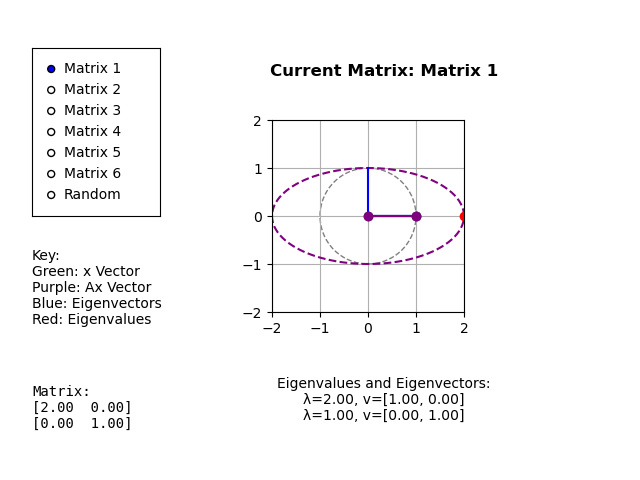

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons
from ipywidgets import interactive

# This is necessary to ensure the plot is interactive in Jupyter Lab
%matplotlib widget

class EigShow:
    def __init__(self, matrices):
        self.matrices = matrices
        self.current_matrix = list(matrices.values())[0]
        self.current_matrix_name = list(matrices.keys())[0]

        # Create interactive plot
        self.fig, self.ax = plt.subplots()
        self.fig.subplots_adjust(left=0.3, right=0.85, top=0.75, bottom=0.35)

        # Unit circle
        self.unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
        self.ax.add_artist(self.unit_circle)

        # Path of Ax
        self.ax_path, = self.ax.plot([], [], 'purple', linestyle='--')

        # Eigenvalues and eigenvectors
        self.eigen_plot, = self.ax.plot([], [], 'o', color='red')
        self.vector_plot, = self.ax.plot([], [], '-', color='blue')

        # Interactive vectors
        self.x_vector, = self.ax.plot([0, 1], [0, 0], '-o', color='green', label='x Vector')
        self.ax_vector, = self.ax.plot([0, 1], [0, 0], '-o', color='purple', label='Ax Vector')

        self.dragging = False

        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)
        self.ax.set_aspect('equal')
        self.ax.grid(True)

        # Current matrix name above the plot
        self.title_ax = plt.axes([0.3, 0.8, 0.6, 0.1], frameon=False)
        self.title_ax.axis('off')
        self.title_display = self.title_ax.text(
            0.5, 0.5, f"Current Matrix: {self.current_matrix_name}",
            ha='center', va='center', fontsize=12, fontweight='bold'
        )

        # Legend (key) below the radio buttons
        self.key_ax = plt.axes([0.05, 0.3, 0.2, 0.2], frameon=False)
        self.key_ax.axis('off')
        self.key_display = self.key_ax.text(
            0.0, 0.5,
            "Key:\nGreen: x Vector\nPurple: Ax Vector\nBlue: Eigenvectors\nRed: Eigenvalues",
            ha='left', va='center', fontsize=10
        )

        # Matrix display below the key
        self.matrix_ax = plt.axes([0.05, 0.05, 0.2, 0.2], frameon=False)
        self.matrix_ax.axis('off')
        self.matrix_display = self.matrix_ax.text(
            0.0, 0.5, self.format_matrix(self.current_matrix),
            ha='left', va='center', fontsize=10, family='monospace'
        )

        self.init_controls()
        self.update_plot()
        self.connect_events()

    def init_controls(self):
        # Radio buttons for matrix selection
        self.radio_ax = plt.axes([0.05, 0.55, 0.2, 0.35], frameon=True)
        self.radio = RadioButtons(self.radio_ax, list(self.matrices.keys()))
        self.radio.on_clicked(self.select_matrix)

        # Eigenvalues and eigenvectors display below the plot
        self.text_ax = plt.axes([0.3, 0.05, 0.6, 0.2], frameon=False)
        self.text_ax.axis('off')
        self.text_display = self.text_ax.text(
            0.5, 0.5, "", ha='center', va='center', fontsize=10, wrap=True
        )

    def connect_events(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_mouse_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_mouse_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_mouse_motion)

    def select_matrix(self, label):
        if label in self.matrices:
            self.current_matrix = self.matrices[label]
            self.current_matrix_name = label
            self.reset_x_vector()
            self.update_plot()

    def reset_x_vector(self):
        # Reset x vector to initial position
        self.x_vector.set_data([0, 1], [0, 0])
        Ax = self.current_matrix @ np.array([1, 0])
        self.ax_vector.set_data([0, Ax[0]], [0, Ax[1]])
        self.update_path()

    def update_path(self):
        # Get points on the unit circle
        theta = np.linspace(0, 2 * np.pi, 100)
        circle = np.array([np.cos(theta), np.sin(theta)])
        
        # Transform the circle by the current matrix
        transformed_circle = self.current_matrix @ circle

        # Update the path of Ax
        self.ax_path.set_data(transformed_circle[0, :], transformed_circle[1, :])

    def update_plot(self):
        A = self.current_matrix
        eigenvalues, eigenvectors = np.linalg.eig(A)

        # Update title with current matrix name
        self.title_display.set_text(f"Current Matrix: {self.current_matrix_name}")

        # Update eigenvalues plot
        self.eigen_plot.set_data(np.real(eigenvalues), np.imag(eigenvalues))

        # Update eigenvectors plot
        self.vector_plot.set_data([], [])
        for i in range(eigenvectors.shape[1]):
            vec = eigenvectors[:, i]
            self.vector_plot.set_data(
                np.append(self.vector_plot.get_xdata(), [0, vec[0].real]),
                np.append(self.vector_plot.get_ydata(), [0, vec[1].real])
            )

        # Update path of Ax
        self.update_path()

        # Update matrix display
        self.matrix_display.set_text(self.format_matrix(self.current_matrix))

        # Update eigenvalues and eigenvectors text
        table_text = "Eigenvalues and Eigenvectors:\n"
        for i in range(len(eigenvalues)):
            table_text += (f"λ={eigenvalues[i]:.2f}, v=[{eigenvectors[0, i]:.2f}, {eigenvectors[1, i]:.2f}]\n")
        self.text_display.set_text(table_text)

        self.fig.canvas.draw_idle()

    def format_matrix(self, matrix):
        """Format the matrix for display."""
        return f"Matrix:\n[{matrix[0,0]:.2f}  {matrix[0,1]:.2f}]\n[{matrix[1,0]:.2f}  {matrix[1,1]:.2f}]"

    def on_mouse_press(self, event):
        if event.inaxes == self.ax:
            self.dragging = True
            self.update_vectors(event)

    def on_mouse_release(self, event):
        self.dragging = False

    def on_mouse_motion(self, event):
        if self.dragging and event.inaxes == self.ax:
            self.update_vectors(event)

    def update_vectors(self, event):
        if event.xdata is None or event.ydata is None:
            return
        x, y = event.xdata, event.ydata
        magnitude = np.sqrt(x**2 + y**2)
        if magnitude == 0:
            return
        x, y = x / magnitude, y / magnitude

        self.x_vector.set_data([0, x], [0, y])
        Ax = self.current_matrix @ np.array([x, y])
        self.ax_vector.set_data([0, Ax[0]], [0, Ax[1]])

        self.fig.canvas.draw_idle()

    def show(self):
        plt.show()

# Define matrices
matrices = {
    "Matrix 1": np.array([[2, 0], [0, 1]]),
    "Matrix 2": np.array([[2, 0], [0, -1]]),
    "Matrix 3": np.array([[0, 1], [1, 0]]),
    "Matrix 4": np.array([[0, 1], [-1, 0]]),
    "Matrix 5": np.array([[1, 1], [1, 1]]),
    "Matrix 6": np.array([[1, 1], [0, 1]]),
    "Random": np.random.randn(2, 2),
}

# Create the interactive EigShow object
eig_show = EigShow(matrices)

# Show the plot in the notebook
eig_show.show()